In [2]:
import networkx as nx
import osmnx as ox
import geopandas as gpd
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from lxml import etree


def lon_lat_trail_to_gpx(
    query,
    lon_lat_trail, 
    file_path,
):
    
    """
    Write the list of lon, lat coordinates to a GPX (XML) file.
    """
    
    track = etree.Element('trk')
    doc = etree.ElementTree(track)
    segment = etree.SubElement(track, 'trkseg')

    for point in lon_lat_trail:
        lon, lat = point
        
        point = etree.SubElement(
            segment,
            'trkpt',
            lon=str(lon), 
            lat=str(lat)
        )

    tree = track.getroottree()
    
    if file_path is None:
        file_path = './' + query + '.gif'
    
    tree.write(
        file_path, 
        pretty_print=True,
        xml_declaration=True, 
        encoding='utf-8'
    )


def animate_from_trail(
    query,
    lon_lat_trail,
    original_edges,
    file_path,
    fig_size,
    frame_share,
    dpi
):
    """
    Create GIF animation of trail from lon, lat coordinates. 
    Projects the points in the trail to UTM and uses the 
    GeoDataFrame.plot() method to plot the background edges.
    """
    
    points = [Point(x, y) for x, y in lon_lat_trail]
    series = gpd.GeoSeries(points)

    gdf = gpd.GeoDataFrame(geometry=series,
                           crs=original_edges.crs)
    
    gdf = ox.project_gdf(gdf)

    increment = int(1/frame_share)
    
    x, y = gdf.geometry.x, gdf.geometry.y
    x, y = x.tolist(), y.tolist()
    x, y = x[::increment], y[::increment]
    
    plt.ioff()
    
    fig, ax = plt.subplots(figsize=(fig_size, fig_size))

    for key, spine in ax.spines.items():
        spine.set_visible(False)

    ax.tick_params(left=False, 
                   bottom=False)
    
    ax.tick_params(labelleft=False, 
                   labelbottom=False)

    p = 200
    
    ax.set_xlim([min(x)-p, max(x)+p])
    ax.set_ylim([min(y)-p, max(y)+p])

    bg_edges = ox.project_gdf(original_edges)
    
    bg_edges.plot(
        ax=ax, 
        color='black', 
        alpha=0.5,
        lw=1/5*fig_size
    )

    point, = ax.plot(
        [], 
        [], 
        color='red',
        marker='o',
        ms=4/5*fig_size
    )
    
    line, = ax.plot(
        [], 
        [], 
        color='red', 
        alpha=0.2, 
        lw=4/5*fig_size
    )

    
    def animate(i):
        point.set_data(x[i], y[i])
        line.set_data(x[:i],y[:i])
        return point, line

    
    animation = FuncAnimation(
        fig=ax.figure, 
        func=animate, 
        frames=len(x), 
        interval=50, 
        blit=True
    )
    
    fps = 40*frame_share
    
    if file_path is None:
        file_path = './' + query + '.gif'
           
    animation.save(
        filename=file_path, 
        dpi=dpi, 
        fps=fps
    )
    

def get_source_node(
    start_lon_lat,
    original_edge_gdf,
    original_node_gdf
):
    """
    Return closest OSM node in street network, when a 
    custom lon,lat starting point is provided by user.
    """
    
    start_point = Point(start_lon_lat)
    start_lon_lat_series = gpd.GeoSeries([start_point])

    start_lon_lat_gdf = gpd.GeoDataFrame(
        geometry=start_lon_lat_series,
        crs=original_edge_gdf.crs
    )

    start_lon_lat_gdf = ox.project_gdf(start_lon_lat_gdf)
    projected_nodes = ox.project_gdf(original_node_gdf)

    start_geom = start_lon_lat_gdf.geometry.iloc[0]
    geoms = projected_nodes.geometry

    distances = geoms.apply(lambda x: x.distance(start_geom))
    source = distances.idxmin()
    
    return source
    
def id_trail_to_lon_lat_trail(
    id_trail,
    original_nodes,
    original_edges
):
    
    origin_id = id_trail[0][0]
    origin_node = original_nodes.loc[origin_id]
    lon_lat_trail = [(origin_node.x, origin_node.y)]
    
    index = original_edges.index
    step_dic = {edge:0 for edge in id_trail}
    
    for edge in id_trail:
        is_edge = [set(edge).issubset(i) for i in index]  
        gdf_edges = original_edges[is_edge]
        
        geom = gdf_edges.geometry   
        step = step_dic[edge]
        
        coords = list(geom.iloc[step].coords)

        test_order = lon_lat_trail[-1] == coords[0]  
        order = 1 if test_order else -1
        lon_lat_trail.extend(coords[::order])

        n_edges = len(gdf_edges)

        if n_edges > 1:
            step_dic[edge] = (step + 1) % n_edges
        
    return lon_lat_trail
    
# add "quiet" argument for saving only
    
def eulerian_trail_from_place(
    query,
    query_type='place',
    network_type='all_private',
    trail_type='circuit',
    start_lon_lat=None,
    save_trail_as_gpx=False,
    gpx_fp=None,
    save_animation=False,
    animation_fp=None,
    animation_fig_size=5,
    animation_frame_share=1,
    animation_dpi=80
):
    """
    Return Eulerian circuit or path as LineString, from city name, bounding box,
    or (address, dist) tuple. Queries are passed to ox.graph.graph_from_place, 
    ox.graph.graph_from_bbox, or ox.graph.graph_from_address. If the query is a 
    place name, it must be geocodable and have polygon boundaries. If the query
    is a bounding box, it must be in (north, south, east, west) format. If
    the query is an address, it must take the form (address, dist) with
    dist the distance from the address within which nodes will be retained.
    """
    
    if query_type == 'place':
        city = ox.graph.graph_from_place(
            query, 
            network_type=network_type
        )
        
    elif query_type == 'bbox':
        city = ox.graph.graph_from_bbox(
            *query, 
            network_type=network_type
        )
    
    elif query_type == 'address':
        city = ox.graph.graph_from_address(
            *query, 
            network_type=network_type
        )
    
    city = city.to_undirected()
    original_nodes, original_edges = ox.graph_to_gdfs(city)
    
    if start_lon_lat is not None:
        source = get_source_node(
            start_lon_lat,
            original_edges,
            original_nodes
        )
        
    else:
        source = None
    
    if trail_type == 'path':
        if nx.has_eulerian_path(city):
            id_trail = list(nx.eulerian_path(city,source=source))
            
        else:
            raise nx.NetworkXError('Graph has no Eulerian paths.')
            
    if trail_type == 'circuit':      
        if not nx.is_eulerian(city):
            city = nx.eulerize(city)

        id_trail = list(nx.eulerian_circuit(city,source=source))
        
    lon_lat_trail = id_trail_to_lon_lat_trail(
        id_trail,
        original_nodes,
        original_edges
    )
            
    if save_trail_as_gpx == True:
        lon_lat_trail_to_gpx(
            query,
            lon_lat_trail, 
            gpx_fp,
        )
        
    if save_animation == True:
        animate_from_trail(
            query,
            lon_lat_trail,
            original_edges,
            animation_fp,
            animation_fig_size,
            animation_frame_share,
            animation_dpi
        )
                    
    lon_lat_trail = LineString(lon_lat_trail)
    
    return lon_lat_trail

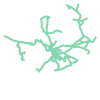

In [4]:
start = (4.373818, 45.318257)

eulerian_trail_from_place(
    query='Jonzieux',
    network_type='drive',
    start_lon_lat=start, 
    save_trail_as_gpx=True,
    gpx_fp = './Examples/Jonzieux.gpx',
    save_animation=True,
    animation_fp = './Examples/Jonzieux.gif'
)

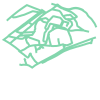

In [5]:
eulerian_trail_from_place(
    query=('42 Montée du Petit Versailles', 800),
    query_type='address',
    network_type='drive',
    save_trail_as_gpx=True,
    gpx_fp = './Examples/Caluire_address.gpx',
)

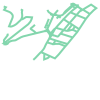

In [6]:
eulerian_trail_from_place(
    query=(45.79, 45.78, 4.84, 4.80),
    query_type='bbox',
    network_type='drive',
    save_trail_as_gpx=True,
    gpx_fp = './Examples/Vaise_bbox.gpx',
)